# **HANDLE OVERFITTING**
Overfitting occurs when the model performs well on training data but generalizes poorly to unseen data. Overfitting is a very common problem in Machine Learning and there has been an extensive range of literature dedicated to studying methods for preventing overfitting. In the following, I’ll describe eight simple approaches to alleviate overfitting by introducing only one change to the data, model, or learning algorithm in each approach.

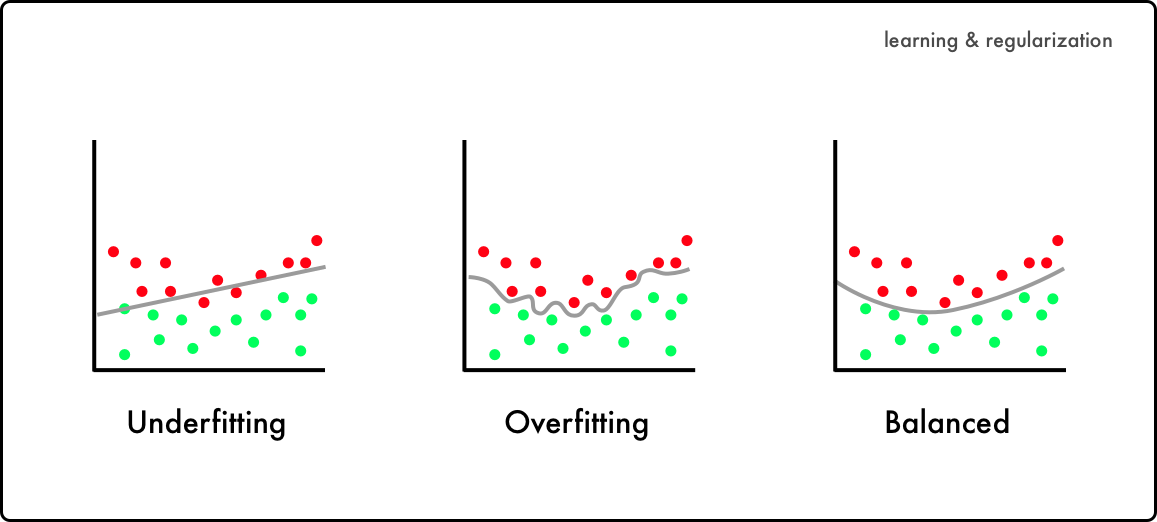

## **Pruning (Tree-based)**
Pruning removes splits directly from the trees during or after the build process

    - Preprunning
    - Postpruning

Paramaters:
- **gamma (min_split_loss)** - A fixed threshold of gain improvement to keep a split. (threshold=batas)
- **min_child_weight** - Minimum sum of Hessians (second derivatives) needed to keep a child node during partitioning. Making this larger makes the algorithm more conservative (although this scales with data size). Since the second derivatives are different in classification and regression, this parameter acts differently for the two contexts. 
    - In regression this is just floor on the number of data instances (rows) that a node needs to see. 
    - For classification this gives the required sum of p*(1-p), where p is the probability, for data that are split into that node. Since probability ranges from 0 to 1, p*(1-p) ranges from 0 to 0.25 and so you will need at least four times the min_child_weight rows in that node to keep it. 
- **max_depth** - The maximum depth of a tree. While not technically pruning, this parameter acts as a hard stop on the tree build process. Shallower trees are weaker learners and are less prone to overfit
- **min_sample_split**: The minimum number of samples required to split an internal node
- **min_samples_leaf**: The minimum number of samples required to be at a leaf node.

In [73]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore')
sns.set(rc={'figure.figsize':(16,5)})
sns.set_context('notebook')
sns.set_palette('cool')

In [116]:
path = './dataset/heart-disease.csv'
df = pd.read_csv(path)
# df = df.sample(303, random_state=0).reset_index(drop=True)
df = df.head(500)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,59,1,0,135,234,0,1,161,0,0.5,1,0,3,1
496,68,1,2,180,274,1,0,150,1,1.6,1,0,3,0
497,57,1,1,154,232,0,0,164,0,0.0,2,1,2,0
498,54,1,0,140,239,0,1,160,0,1.2,2,0,2,1


In [117]:
from sklearn.model_selection import train_test_split
from sklearn import tree

x, y = df.drop('target', axis=1), df.target
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=0)
# x_train, x_test, y_train, y_test = train_test_split(x,y, stratify=y, random_state=0)
model = tree.DecisionTreeClassifier(random_state=0)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)


In [118]:
from sklearn.metrics import confusion_matrix, accuracy_score
# helper function
def plot_confusionmatrix(y_train_pred,y_train,y_test_pred,y_test,labels):
    # print(f'{dom} Confusion matrix')
    train_score = accuracy_score(y_train_pred, y_train)
    test_score = accuracy_score(y_test_pred, y_test)
    f, ax = plt.subplots(1,2,figsize=(12,5))
    cf_train = confusion_matrix(y_train_pred,y_train)
    cf_test = confusion_matrix(y_test_pred,y_test)
    sns.heatmap(cf_train,annot=True,yticklabels=labels,xticklabels=labels,cmap='Blues', fmt='g', ax=ax[0]).set(
        title=f'Train score {train_score:.2f}',
        xlabel='Predicted', ylabel='Actual')
    sns.heatmap(cf_test,annot=True,yticklabels=labels,xticklabels=labels,cmap='Blues', fmt='g', ax=ax[1]).set(
        title=f'Test score {test_score:.2f}',
        xlabel='Predicted', ylabel='Actual')
    plt.tight_layout()

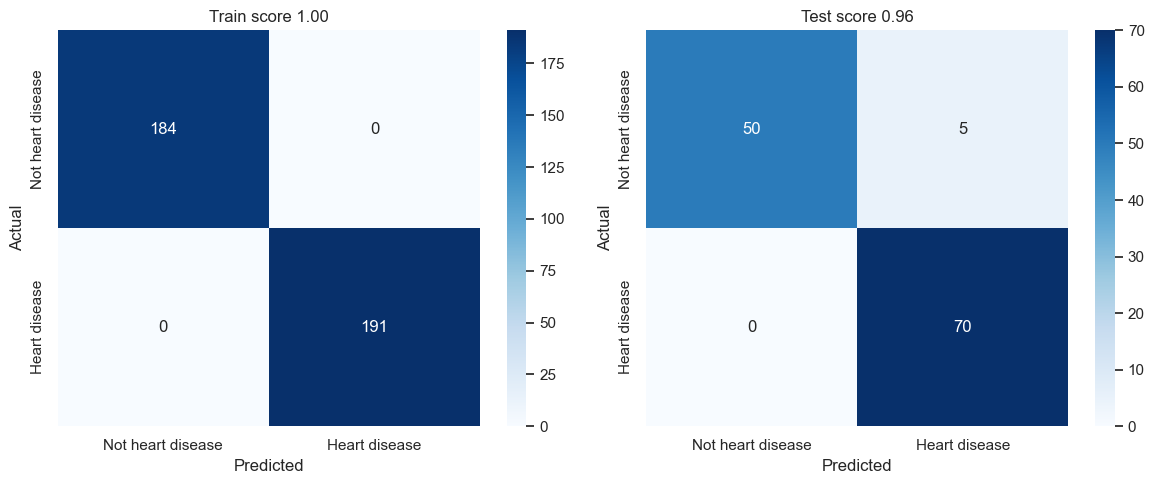

In [119]:
labels = ['Not heart disease', 'Heart disease']
plot_confusionmatrix(y_train_pred,y_train,y_test_pred,y_test, labels=labels)

### **Pre-Pruning with OPTUNA**

In [120]:
import optuna
from optuna.samplers import GridSampler
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import accuracy_score

def objective(trial, x, y, cv, scoring):
    params = {
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 2),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 4),
        "max_depth": trial.suggest_int("max_depth", 2, 12, step=2),
        "random_state": 0,
        # "n_iter_no_change": 50,  # early stopping
    }
    # Perform CV
    model = tree.DecisionTreeClassifier(**params)
    #1
    # model.fit(x,y)
    # y_pred = model.predict(x)
    # acc = accuracy_score(y_pred, y)
    #2
    scores = cross_validate(model, x, y, cv=cv, scoring=scoring, n_jobs=-1)
    acc = scores["test_score"].mean()
    return acc

x, y = df.drop('target', axis=1), df.target
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=0)
kf = KFold(n_splits=3, shuffle=True, random_state=0)
func = lambda trial: objective(trial, x_train, y_train, cv=kf, scoring="accuracy")
study = optuna.create_study(direction="maximize")
study.optimize(func, n_trials=100)

[I 2023-04-07 13:30:07,955] A new study created in memory with name: no-name-660f6064-aab0-4e24-b5c7-e2e4a25f24b9
[I 2023-04-07 13:30:07,975] Trial 0 finished with value: 0.8533333333333334 and parameters: {'min_samples_leaf': 2, 'min_samples_split': 2, 'max_depth': 8}. Best is trial 0 with value: 0.8533333333333334.
[I 2023-04-07 13:30:07,995] Trial 1 finished with value: 0.8586666666666667 and parameters: {'min_samples_leaf': 1, 'min_samples_split': 4, 'max_depth': 8}. Best is trial 1 with value: 0.8586666666666667.
[I 2023-04-07 13:30:08,013] Trial 2 finished with value: 0.8533333333333334 and parameters: {'min_samples_leaf': 2, 'min_samples_split': 4, 'max_depth': 8}. Best is trial 1 with value: 0.8586666666666667.
[I 2023-04-07 13:30:08,029] Trial 3 finished with value: 0.848 and parameters: {'min_samples_leaf': 1, 'min_samples_split': 3, 'max_depth': 6}. Best is trial 1 with value: 0.8586666666666667.
[I 2023-04-07 13:30:08,047] Trial 4 finished with value: 0.8533333333333334 and

In [121]:
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Best params:
	min_samples_leaf: 1
	min_samples_split: 3
	max_depth: 8


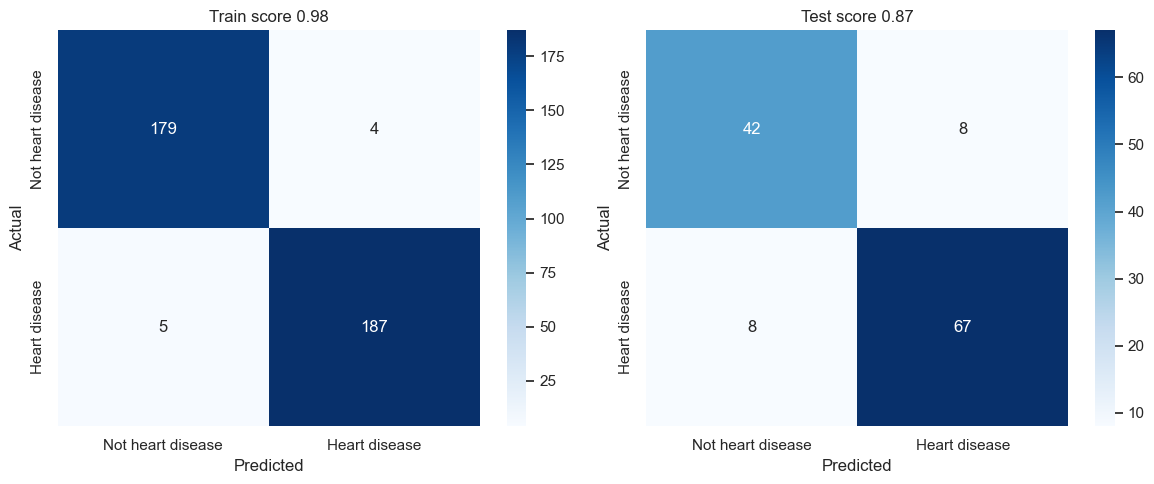

In [122]:
model = tree.DecisionTreeClassifier(random_state=0, min_samples_leaf=2, min_samples_split=3, max_depth=8)
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

labels = ['Not heart disease', 'Heart disease']
plot_confusionmatrix(y_train_pred,y_train,y_test_pred,y_test, labels=labels)

### **Pre-Prunning with GridCV**

{'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 0}


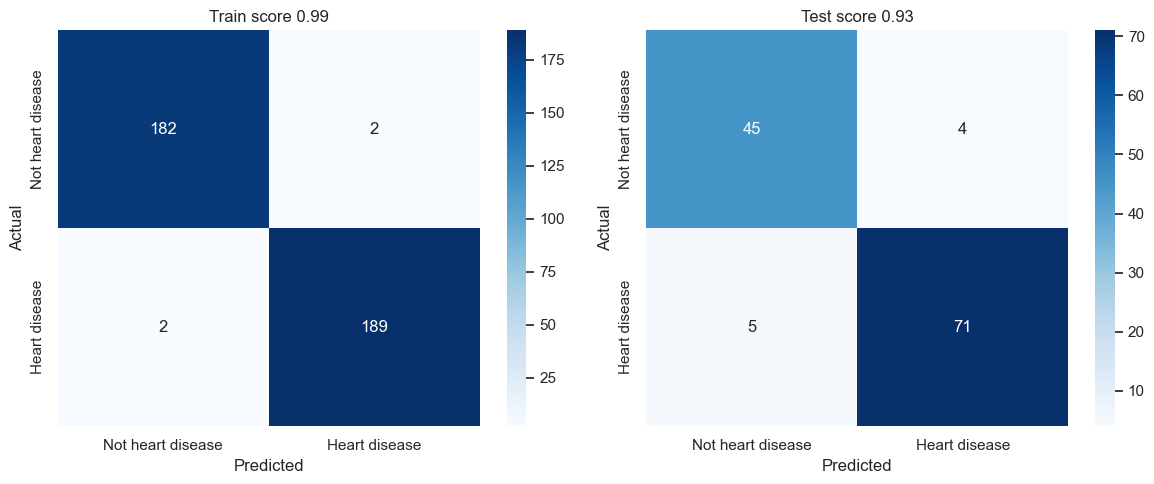

In [123]:
from sklearn.model_selection import GridSearchCV

x, y = df.drop('target', axis=1), df.target
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=0)
params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2],
         'random_state': [0]}
kf = KFold(n_splits=3, shuffle=True, random_state=0)

clf = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params, cv=kf)
gcv.fit(x_train,y_train)

print(gcv.best_params_)

model = gcv.best_estimator_
model.fit(x_train,y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

labels = ['Not heart disease', 'Heart disease']
plot_confusionmatrix(y_train_pred,y_train,y_test_pred,y_test, labels=labels)

### **Post-Pruning**